# Load Data

In [67]:
from pysheds.grid import Grid

file_path = 'py_output/DEM_IDW_MGA2020.tif'

grid = Grid.from_raster(file_path)
dem = grid.read_raster(file_path)

/opt/miniconda3/envs/geo/lib/python3.12/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')
/opt/miniconda3/envs/geo/lib/python3.12/site-packages/pysheds/io.py:134: UserWarning: No `nodata` value detected. Defaulting to 0.
  warnings.warn('No `nodata` value detected. Defaulting to 0.')


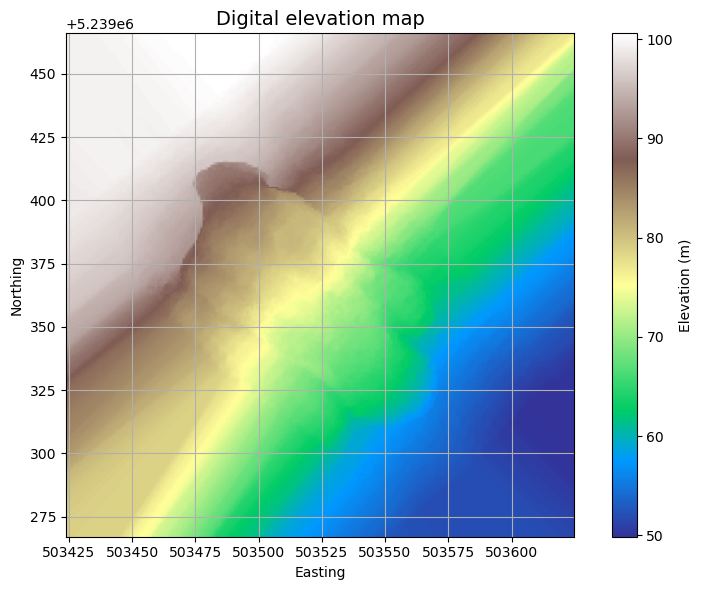

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.tight_layout()

# Fill Pits

In [69]:
pits = grid.detect_pits(dem)

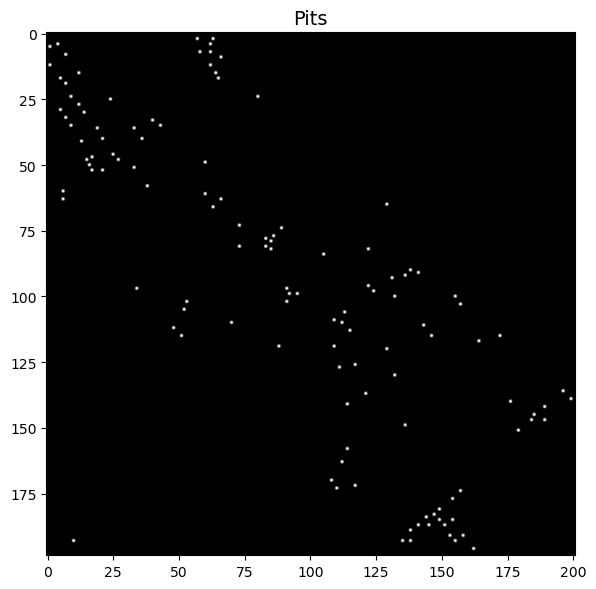

In [70]:
# Plot pits
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(pits, cmap='Greys_r', zorder=1)
plt.title('Pits', size=14)
plt.tight_layout()

In [71]:
pit_filled_dem = grid.fill_pits(dem)
pits = grid.detect_pits(pit_filled_dem)
assert not pits.any()

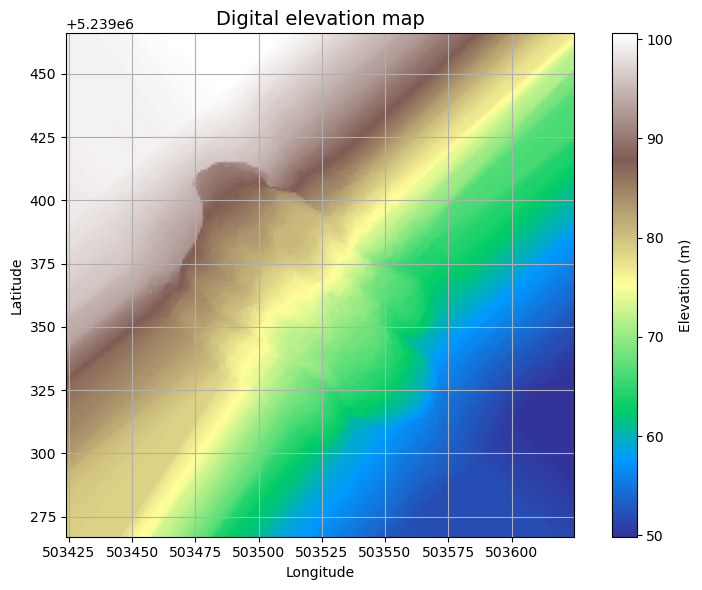

In [72]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(pit_filled_dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()


# Fill depressions

I understand the difference between pits and depressions, but I'm not sure what ArcGIS looked at. Did it only consider pits? Anyway doesn't really matter for this case as there are no depressions.

In [73]:
depressions = grid.detect_depressions(pit_filled_dem)
depressions.any()

Raster(False)

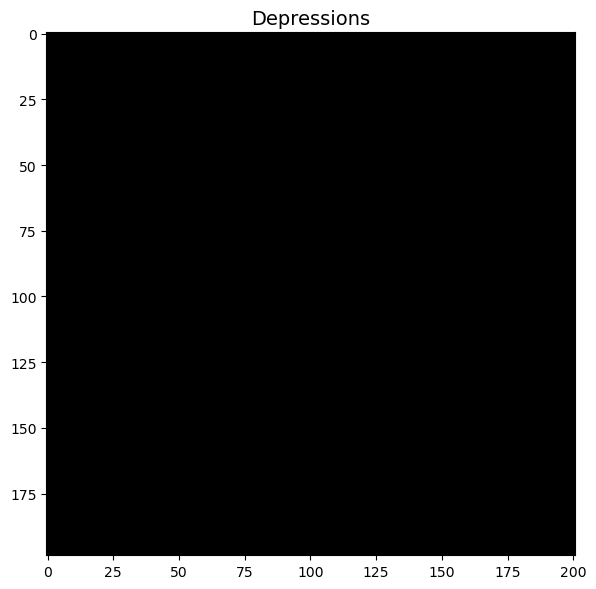

In [74]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(depressions, cmap='Greys_r', zorder=1)
plt.title('Depressions', size=14)
plt.tight_layout()

In [75]:
# note this step wasn't required
# Fill depressions
flooded_dem = grid.fill_depressions(pit_filled_dem)
depressions = grid.detect_depressions(flooded_dem)
assert not depressions.any()

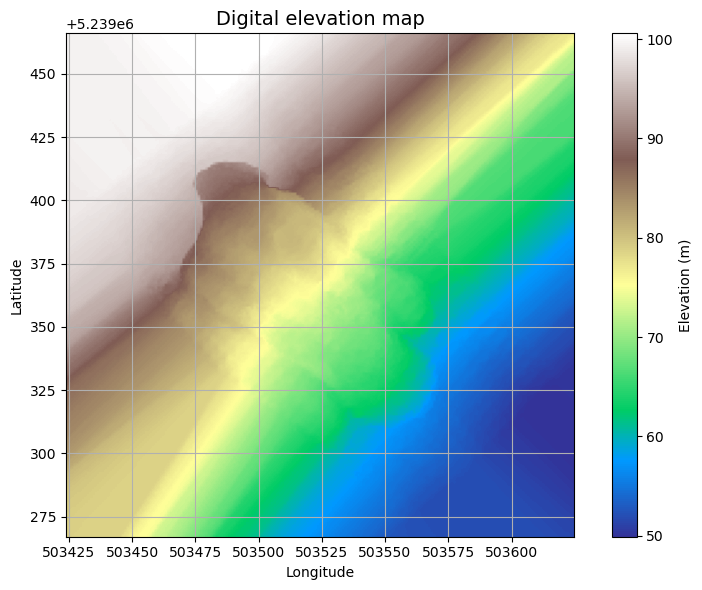

In [76]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(flooded_dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Flats

I don't believe we solved for flats in ArcGIS, however the example code from Pysheds did so 🤷

In [77]:
flats = grid.detect_flats(flooded_dem)

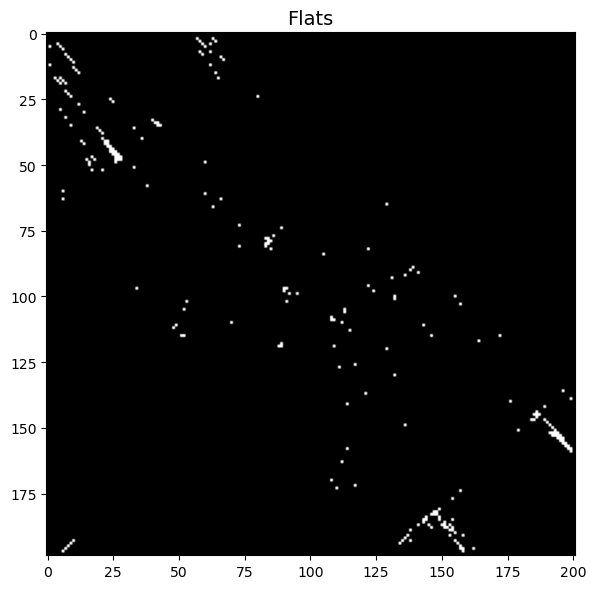

In [78]:
# Plot flats
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(flats, cmap='Greys_r', zorder=1)
plt.title('Flats', size=14)
plt.tight_layout()

In [79]:
inflated_dem = grid.resolve_flats(flooded_dem)
flats = grid.detect_flats(inflated_dem)
assert not flats.any()

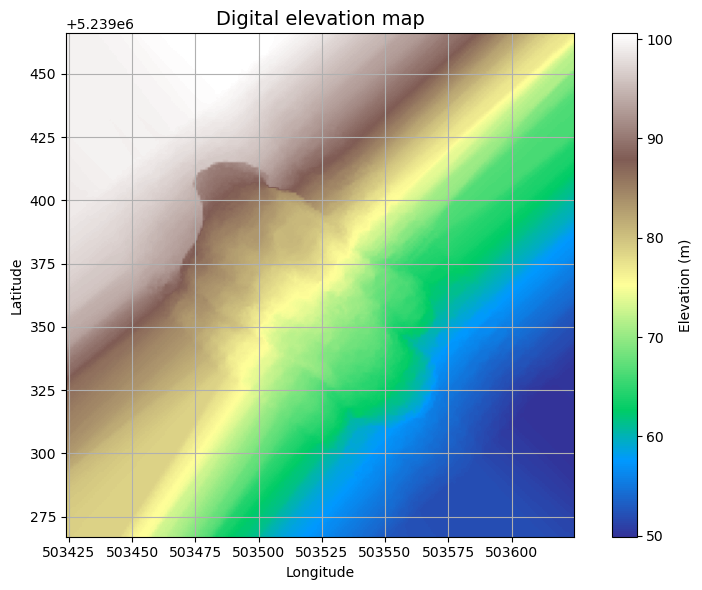

In [80]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(inflated_dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map', size=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()

# Flow Direction and Accumulation

In [107]:
# Compute flow direction based on corrected DEM
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
fdir = grid.flowdir(inflated_dem)

# Compute flow accumulation based on computed flow direction
acc = grid.accumulation(fdir)

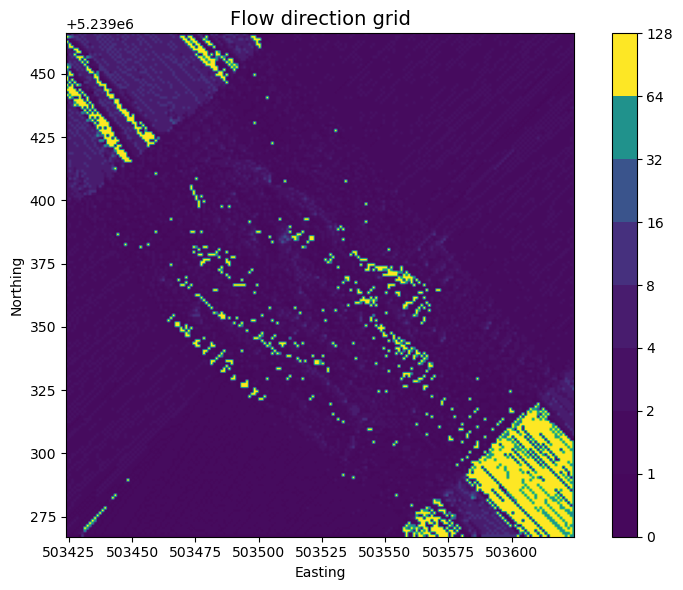

In [108]:
fig = plt.figure(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(fdir, extent=grid.extent, cmap='viridis', zorder=2)
boundaries = ([0] + sorted(list(dirmap)))
plt.colorbar(boundaries= boundaries,
             values=sorted(dirmap))
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Flow direction grid', size=14)
plt.grid(zorder=-1)
plt.tight_layout()

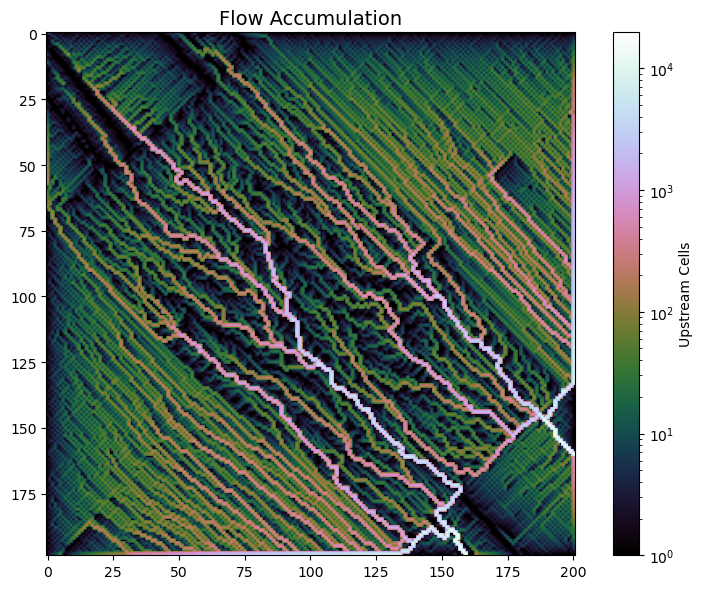

In [83]:
fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
im = ax.imshow(acc, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, acc.max()),
               interpolation='bilinear')
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation', size=14)
plt.tight_layout()

# Stream Vector

In [84]:
streams = grid.extract_river_network(fdir, acc > 250)

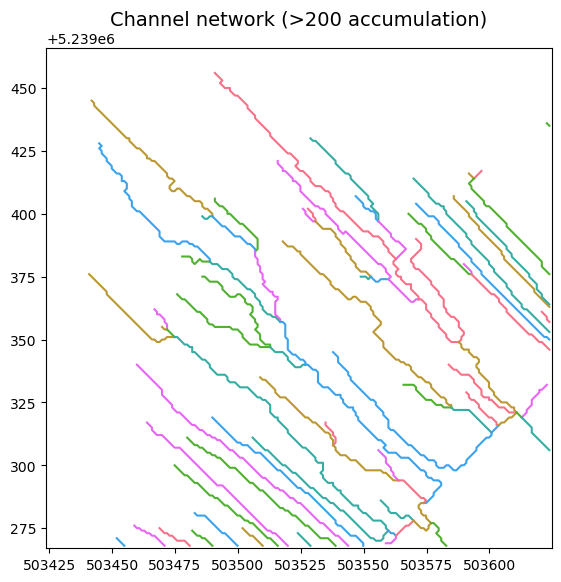

In [85]:
sns.set_palette('husl')
fig, ax = plt.subplots(figsize=(8.5,6.5))

plt.xlim(grid.bbox[0], grid.bbox[2])
plt.ylim(grid.bbox[1], grid.bbox[3])
ax.set_aspect('equal')

for branch in streams['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])
    
_ = plt.title('Channel network (>200 accumulation)', size=14)

# File Output

Because pysheds uses rasterio, we can save our raster files the same as before

In [115]:
import rasterio
def save_raster(raster, name):
    gtiff = rasterio.open(f"py_output/{name}.tif", 'w',
        driver='GTiff',
        height=raster.shape[0],
        width=raster.shape[1],
        count=1,  # Number of bands
        # Force float .. QGIS / GeoTiff didnt like the int64 of flow direction
        dtype=np.float64,   
        crs=raster.crs,
        transform=raster.affine
    )
    gtiff.write(raster, 1)
    gtiff.close()

In [113]:
save_raster(pit_filled_dem, "PitFilledDEM_MGA2020")
save_raster(inflated_dem, "InflatedDEM_MGA2020")
save_raster(fdir, "FlowDirection_MGA2020")
save_raster(acc, "FlowAcc_MGA2020")

In [116]:
import json

# Note - CRS information has not been included in GeoJSON output
# Loading GeoJSON in applications like QGIS will default to WGS84 (EPSG:4326)
# You just need to redfine the CRS to MGA 2020 Zone 55 (EPSG:7855)

with open('py_output/streams_MGA2020.json', 'w') as f:
    json.dump(streams, f)